<a href="https://colab.research.google.com/github/niyatimahajan08/S-P-500-stock-price-prediction/blob/main/LSTM_price_prediction_sp500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance tensorflow numpy pandas matplotlib sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Import neccessary libraries

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



import warnings
warnings.filterwarnings('ignore')

--------------
Data taken from 2019-2009 (20 Year Period)

2020 will only be presented once testing is finalized.

In [ ]:
#Downloading of data from Yahoo Finance which will be used for model training
end = '2020-12-31'
start = '2000-01-02'

trainingData = yf.download('^GSPC', start=start, end=end)
trainingData.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [ ]:
#Downloading of data from Yahoo Finance which will be used for model testing
end = '2025-01-31'
start = '2021-01-02'

testingData = yf.download('^GSPC', start=start, end=end)
testingData.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2021-01-04,3700.649902,3769.989990,3662.709961,3764.610107,5015000000
2021-01-05,3726.860107,3737.830078,3695.070068,3698.020020,4591020000
2021-01-06,3748.139893,3783.040039,3705.340088,3712.199951,6064110000
2021-01-07,3803.790039,3811.550049,3764.709961,3764.709961,5099160000
2021-01-08,3824.679932,3826.689941,3783.600098,3815.050049,4773040000


In [ ]:
# Flatten the MultiIndex columns
trainingData.columns = trainingData.columns.droplevel(1)
testingData.columns = testingData.columns.droplevel(1)

# Display the updated dataframes
trainingData.columns
testingData.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [ ]:
#Prediction will take place on Adj Close price, therefore we must isolate Adj Close.
trainprice = trainingData['Close']
trainData = trainprice.values

testprice = testingData['Close']
testData = testprice.values

In [ ]:
trainData


array([1455.2199707 , 1399.42004395, 1402.10998535, ..., 3735.36010742,
       3727.04003906, 3732.04003906])

Plotting of High vs Low

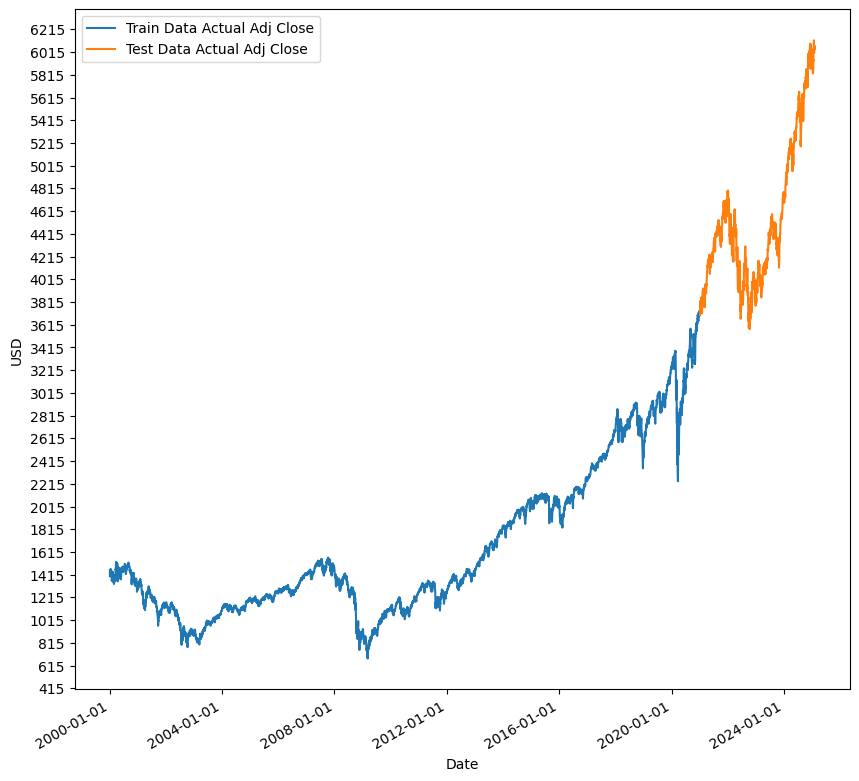

In [ ]:
plt.figure(figsize=(10,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_locator(mdates.DayLocator(interval=200))

plt.plot(trainingData.index, trainingData['Close'], label='Train Data Actual Adj Close')
plt.plot(testingData.index, testingData['Close'], label='Test Data Actual Adj Close')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.transform(testData.reshape(-1, 1))

In [ ]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [ ]:
#LSTM Model

model = Sequential()

#Layer 1
model.add(LSTM(units = 125,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
#model.add(LSTM(units = 125,return_sequences=True))
#model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=75, return_sequences=False))
model.add(Dropout(0.2))
#Layer 4
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_131 (LSTM)                 │ (None, 20, 125)        │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 20, 125)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_132 (LSTM)                 │ (None, 75)             │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,876 (483.89 KB)

 Trainable params: 123,876 (483.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Method to plot the training metric vs validation metric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0497 - mean_absolute_error: 0.1962 - root_mean_squared_error: 0.2150


In [ ]:
len(xTrain)

5263

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0128 - mean_absolute_error: 0.0850 - root_mean_squared_error: 0.1057 - val_loss: 0.0031 - val_mean_absolute_error: 0.0501 - val_root_mean_squared_error: 0.0558
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3678e-04 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0229 - val_loss: 5.0937e-04 - val_mean_absolute_error: 0.0153 - val_root_mean_squared_error: 0.0226
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5739e-04 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0188 - val_loss: 0.0017 - val_mean_absolute_error: 0.0348 - val_root_mean_squared_error: 0.0418
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4887e-04 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0248 - val_loss: 0.0010 - val_mean_absolute_error: 0.0253 - val_root_mean_squared_error: 0.0316
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - mean_absolute_error: 0.0334 

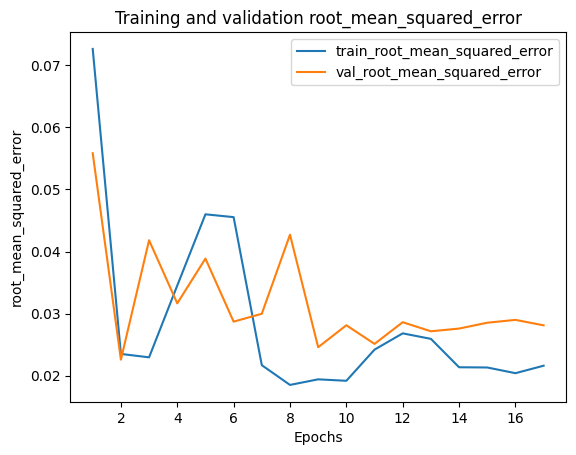

In [ ]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [ ]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))



In [ ]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


np.float64(0.19017705603025079)

In [ ]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - mean_absolute_error: 0.1309 - root_mean_squared_error: 0.1384


The following cells are the joining of the actual data + prediction into a single DF

In [ ]:
df1 = pd.DataFrame(testingData['Close']).astype(float)
df1 = df1.iloc[:-20] # Adjusted to match the length of predictions
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)

In [ ]:
df2

,Pred Adj Close
0,3561.792725
1,3559.656006
2,3560.718262
3,3566.246826
4,3574.709961
...,...
999,4863.960938
1000,4877.537109
1001,4884.411133
1002,4890.268066


In [ ]:
df = df1.join(df2)
df = df.set_index('Date')

In [ ]:
df.columns

Index(['Close', 'Pred Adj Close'], dtype='object')

Results

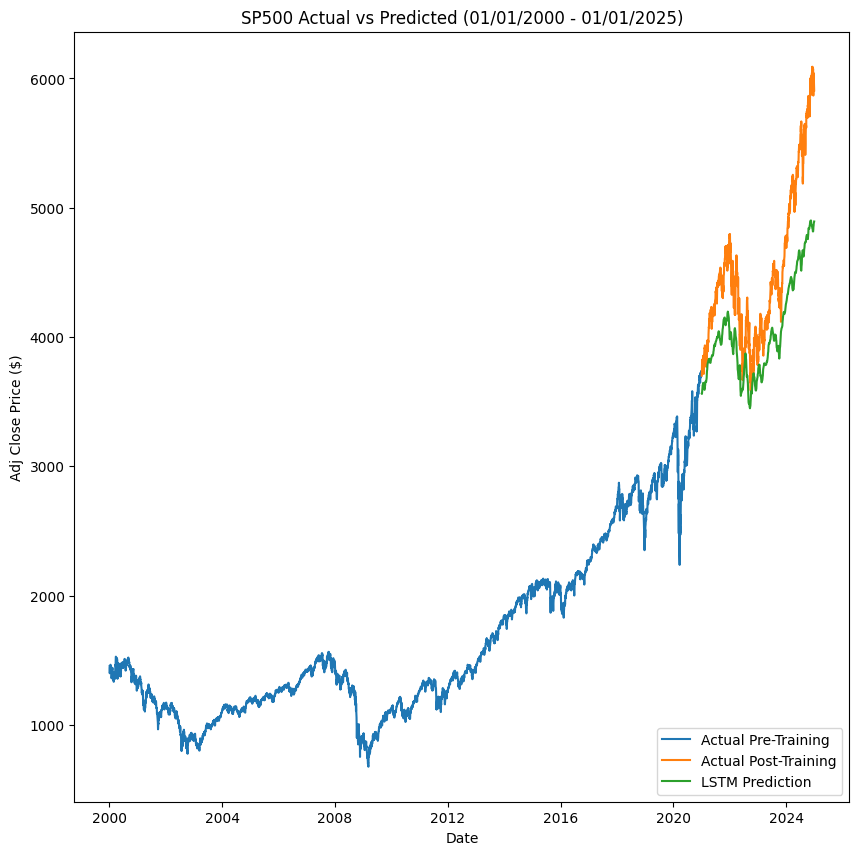

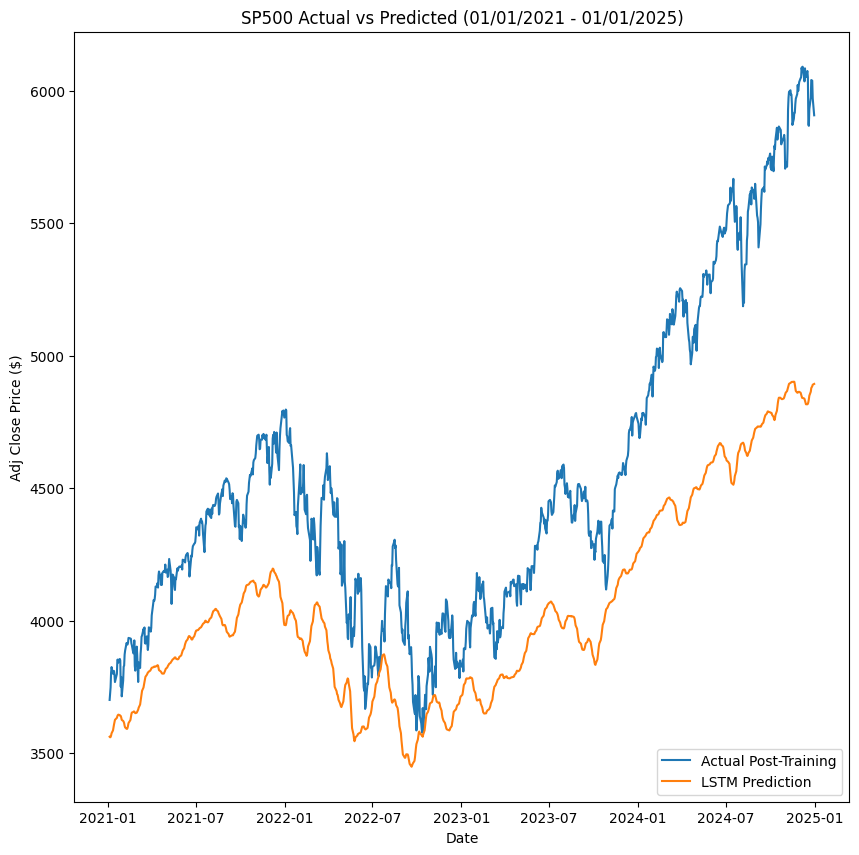

In [ ]:
#plotting of graphs - Full Overview

train = trainingData['Close']
real = df['Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted (01/01/2000 - 01/01/2025)') # Corrected title date range
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(train)
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Pre-Training', 'Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

#plotting of graphs - Test Period Overview
real = df['Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted (01/01/2021 - 01/01/2025)') # Corrected title date range
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()